# 非参数池化注意力

In [3]:
import torch
from torch.nn import functional as F

import numpy as np
from matplotlib import pyplot as plt

from lib.d2l_torch import DataModule, plot, show_heatmaps

In [11]:
def plot_kernel_reg(x_train, y_train, x_test, y_test, y_hat):
    """绘制图像, 将原始数据集和预测的绘制在一起

    Args:
        y_hat (_type_): 预测得到的 y 值
    """
    plot(
        x_test, 
        [y_test, y_hat.detach().numpy()], 'x', 'y', legend=['Truth', 'Pred'],
        xlim=[0, 5], ylim=[-1, 5]
    )
    plt.plot(x_train, y_train, 'o', alpha=0.5)

## 生成数据集 

根据下面的非线性函数生成一个人工数据集， 其中加入的噪声项为ϵ：
$$y_i=2 \sin \left(x_i\right)+x_i^{0.8}+\epsilon$$

In [5]:
n_train = 50  # 训练样本数
x_train = np.sort(np.random.rand(n_train) * 5)   # 排序后的训练样本

print(x_train)

def f(x):
    return 2 * np.sin(x) + x**0.8

y_train = f(x_train) + np.random.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = np.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

[0.23799037 0.45906954 0.53503533 0.54351783 0.64162898 0.64363574
 0.65316794 0.78110853 0.90776158 0.9646891  1.12343279 1.31178582
 1.38554784 1.38970088 1.39350982 1.45438866 1.6253781  1.68123142
 1.73652978 1.96108442 2.55640405 2.6132273  2.6240908  2.85286601
 2.96266242 3.00405533 3.01804304 3.11656538 3.19091733 3.2538964
 3.3395712  3.34080965 3.35939805 3.4046784  3.43281094 3.49572966
 3.49619734 3.54548191 3.7046346  3.99094795 4.01330629 4.2143634
 4.23771423 4.25266255 4.40704433 4.45897861 4.48376011 4.49281501
 4.6490803  4.72947247]


50

## 平均汇聚
先使用最简单的估计器来解决回归问题。 基于平均汇聚来计算所有训练样本输出值的平均值：
$$f(x)=\frac{1}{n} \sum_{i=1}^n y_i$$

In [6]:
y_hat = y_train.mean().repeat(n_test)
y_hat

array([2.42709208, 2.42709208, 2.42709208, 2.42709208, 2.42709208,
       2.42709208, 2.42709208, 2.42709208, 2.42709208, 2.42709208,
       2.42709208, 2.42709208, 2.42709208, 2.42709208, 2.42709208,
       2.42709208, 2.42709208, 2.42709208, 2.42709208, 2.42709208,
       2.42709208, 2.42709208, 2.42709208, 2.42709208, 2.42709208,
       2.42709208, 2.42709208, 2.42709208, 2.42709208, 2.42709208,
       2.42709208, 2.42709208, 2.42709208, 2.42709208, 2.42709208,
       2.42709208, 2.42709208, 2.42709208, 2.42709208, 2.42709208,
       2.42709208, 2.42709208, 2.42709208, 2.42709208, 2.42709208,
       2.42709208, 2.42709208, 2.42709208, 2.42709208, 2.42709208])

显然，平均汇聚忽略了输入$x_i$。 于是Nadaraya (Nadaraya, 1964)和 Watson (Watson, 1964)提出了一个更好的想法， 根据输入的位置对输出$y_i$进行加权：
$$f(x)=\sum_{i=1}^n \frac{K\left(x-x_i\right)}{\sum_{j=1}^n K\left(x-x_j\right)} y_i$$

其中K是核（kernel）。 公式所描述的估计器被称为 Nadaraya-Watson核回归（Nadaraya-Watson kernel regression）。 但受此启发，注意力机制框架的角度重写上面公式， 注意力汇聚（attention pooling）公式：
$$f(x)=\sum_{i=1}^n \alpha\left(x, x_i\right) y_i$$

$(x_i,y_i)$是键值对。  注意力汇聚是$y_i$的加权平均。 将查询x和键$x_i$之间的关系建模为 注意力权重（attention weight）$α(x,x_i)$，这个权重将被分配给每一个对应值$y_i$。 对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布： 它们是非负的，并且总和为1。

为了更好地理解注意力汇聚， 下面考虑一个高斯核（Gaussian kernel），其定义为：
$$K(u)=\frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{u^2}{2}\right)$$

将高斯核代入可以得到：
$$\begin{aligned}
f(x) & =\sum_{i=1}^n \alpha\left(x, x_i\right) y_i \\
& =\sum_{i=1}^n \frac{\exp \left(-\frac{1}{2}\left(x-x_i\right)^2\right)}{\sum_{j=1}^n \exp \left(-\frac{1}{2}\left(x-x_j\right)^2\right)} y_i \\
& =\sum_{i=1}^n \operatorname{softmax}\left(-\frac{1}{2}\left(x-x_i\right)^2\right) y_i .
\end{aligned}$$



In [7]:
X_repeat = x_test.repeat(n_train).reshape((-1, n_train))
print(X_repeat.shape)
attention_weights = F.softmax(-(torch.tensor(X_repeat) - torch.tensor(x_train))**2 / 2)
print("attention", attention_weights.shape)
print("y_train", y_train.shape)

y_hat = np.dot(attention_weights, y_train)
y_hat

(50, 50)
attention torch.Size([50, 50])
y_train (50,)


<ipython-input-7-d64821c657cc>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention_weights = F.softmax(-(torch.tensor(X_repeat) - torch.tensor(x_train))**2 / 2)


array([2.46162894, 2.50303045, 2.54450112, 2.58588464, 2.62699186,
       2.66759566, 2.70742554, 2.74616239, 2.78343369, 2.81881029,
       2.85180548, 2.88187784, 2.90843923, 2.93086946, 2.94853872,
       2.96083814, 2.96721766, 2.96722872, 2.96056744, 2.94711259,
       2.92695202, 2.90039204, 2.86794648, 2.83030559, 2.78828858,
       2.7427865 , 2.69470348, 2.64490393, 2.59417124, 2.54318067,
       2.49248676, 2.44252308, 2.39361124, 2.3459759 , 2.29976239,
       2.25505476, 2.21189237, 2.1702842 , 2.1302203 , 2.09168048,
       2.05464037, 2.01907534, 1.98496256, 1.95228181, 1.92101517,
       1.89114633, 1.86265936, 1.83553755, 1.8097622 , 1.78531171])

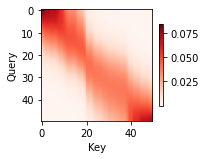

In [8]:
show_heatmaps(
    [[attention_weights]],
    xlabel='Key',
    ylabel='Query'
)

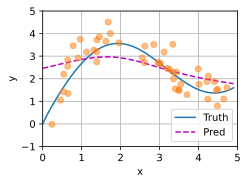

In [12]:
plot_kernel_reg(x_train, y_train, x_test, y_truth, torch.tensor(y_hat))